In [3]:
import numpy as np
import pandas as pd

from scipy import stats
import itertools
from sklearn import linear_model
from numpy import ones,vstack
from numpy.linalg import lstsq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import statsmodels.api as sm;

pd.options.display.max_columns = 150;

Ture = True;

In [4]:
from sklearn import ensemble;
from sklearn.preprocessing import LabelEncoder

In [5]:
typedict = {#'PID' : 'nominal',
            'SalePrice' : 'Continuous',
            #Matt
            'LotFrontage' : 'Continuous', 
            'LotArea' : 'Continuous',
            'maybe_LotShape' : 'Nominal',
            'LandSlope' : 'Nominal', 
            'LandContour' : 'Nominal', 
            'maybe_MSZoning' : 'Nominal', 
            'Street_paved' : 'Nominal', 
            'Alley' : 'Nominal',
            'Neighborhood' : 'Nominal', 
            'Foundation' : 'Nominal',
            'Utilities' : 'Nominal',
            'Heating' : 'Nominal',
            'HeatingQC_nom' : 'Ordinal',
            'CentralAir' : 'Nominal',
            'Electrical' : 'Nominal',
            'HeatingQC_ord' : 'Ordinal',
            'LotShape_com' : 'Nominal',
            'MSZoning_com' : 'Nominal',
            'LF_Near_NS_RR' : 'Nominal',
            'LF_Near_Positive_Feature' : 'Nominal',
            'LF_Adjacent_Arterial_St' : 'Nominal',
            'LF_Near_EW_RR' : 'Nominal',
            'LF_Adjacent_Feeder_St' : 'Nominal',
            'LF_Near_Postive_Feature' : 'Nominal',
            'Heating_com' : 'Nominal',
            'Electrical_com' : 'Nominal',
            'LotConfig_com' : 'Nominal', 
            'LotFrontage_log' : 'Continuous',
            'LotArea_log' : 'Continuous',
            #Oren 
            'MiscFeature': 'Nominal',
            'Fireplaces': 'Discrete',
            'FireplaceQu': 'Ordinal',
            'PoolQC': 'Ordinal',
            'PoolArea': 'Continuous',
            'PavedDrive': 'Nominal',
            'ExterQual': 'Ordinal',
            'OverallQual': 'Ordinal',
            'maybe_OverallCond': 'Ordinal',
            'MiscVal': 'Continuous',
            'YearBuilt': 'Discrete',
            'YearRemodAdd': 'Discrete',
            'KitchenQual': 'Ordinal',
            'Fence': 'Ordinal',
            'RoofStyle': 'Nominal',
            'RoofMatl': 'Nominal',
            'maybe_ExterCond': 'Ordinal',
            'maybe_MasVnrType': 'Nominal',
            'MasVnrArea': 'Continuous',
            #Mo
            'BsmtQual_ord': 'Ordinal',
            'BsmtCond_ord': 'Ordinal',
            'BsmtExposure_ord': 'Ordinal',
            'TotalBsmtSF': 'Continuous',
            'BSMT_GLQ':'Continuous', 
            'BSMT_Rec':'Continuous',
            'maybe_BsmtUnfSF': 'Continuous',
            'maybe_BSMT_ALQ':'Continuous',
            'maybe_BSMT_BLQ':'Continuous', 
            'maybe_BSMT_LwQ':'Continuous', 
            #Deck
            'WoodDeckSF':'Continuous', 
            'OpenPorchSF':'Continuous', 
            'ScreenPorch':'Continuous',
            'maybe_EnclosedPorch':'Continuous',
            'maybe_3SsnPorch':'Continuous',
            #Garage
            'GarageFinish':'Nominal', 
            'GarageYrBlt':'Continuous',
            'GarageCars':'Ordinal',
            'GarageArea':'Continuous',
            'GarageType_con':'Nominal',
            'maybe_GarageQual':'Nominal', 
            'maybe_GarageCond':'Nominal',

            # Hao-Wei
            "SaleType": "Nominal",
            "BldgType": "Nominal",
            "Functional_ord": "Ordinal", # Changed from "Functional"
            "1stFlrSF": "Continuous",
            "2ndFlrSF": "Continuous",
            "maybe_LowQualFinSF": "Continuous", # Rejectable p-value
            "GrLivArea": "Continuous",
            "BsmtFullBath": "Discrete",
            "maybe_BsmtHalfBath": "Discrete", # Rejectable p-value
            "FullBath": "Discrete",
            "maybe_HalfBath": "Discrete",
            "BedroomAbvGr": "Discrete",
            "KitchenAbvGr": "Discrete",
            "TotRmsAbvGrd": "Discrete",
            "MoSold": "Discrete", # Rejectable p-value
            "YrSold": "Discrete", # Rejectable p-value
            "1stFlrSF_log": "Continuous",
            "2ndFlrSF_log": "Continuous",
            "GrLivArea_log": "Continuous",
            "number_floors": "Discrete",
            "attic": "Ordinal",
            "PUD": "Nominal",
            #### Whose?
            "SaleCondition": "Nominal",
            "SalePrice_log": "Continuous",
            "MS_coded": "Nominal",
            "sold_datetime": "Discrete",
    
            # Used locally in this notebook
            "Months_Elapsed": "Discrete"
}

In [6]:
attic_dict = {"No attic": 0, "Finished": 2, "Unfinished": 1};
fence_dict = {"No Fence": 0, "Minimum Privacy": 3, "Good Privacy": 4, "Good Wood": 2 , "Minimum Wood/Wire": 1};
PoolQC_dict = {0:0, "0":0, "Fa": 1, "TA":2, "Gd":3, "Ex":4};

In [7]:
housing = pd.read_csv('../data/ames_housing_price_data_v2.csv', index_col = 0);

In [8]:
y = housing["SalePrice"];
ylog = housing["SalePrice_log"];

x = housing.drop(["SalePrice", "SalePrice_log"], axis = 1);
x = x.fillna(0);

In [9]:
# Drop the column sold_datetime and replace with a column which computes the time elapsed since 2006-01.
# I don't like sold_datetime much, and sklearn often have difficulty understanding it.

x.drop("sold_datetime", axis = 1, inplace = True);
x["Months_Elapsed"] = 12*(x["YrSold"]-2006) + x["MoSold"];
x["attic"] = x.apply(lambda t: attic_dict[t["attic"]], axis = 1);
x["Fence"] = x.apply(lambda t: fence_dict[t["Fence"]], axis = 1);
x["PoolQC"] = x.apply(lambda t: PoolQC_dict[t["PoolQC"]], axis = 1);

x.drop("HeatingQC_nom", axis = 1, inplace = True);

In [10]:
col_num = [w for w in x.columns if typedict[w] in ["Continuous", "Discrete", "Ordinal"]];
col_nom = [w for w in x.columns if typedict[w] == "Nominal"];
# TODO: Not avery ordinal variables are in the machine understandable way.
# Fix: HeatingQC_nom, Fence, attic

x_num = x[col_num];
x_nom = x[col_nom];

In [11]:
# Encode all nominal and ordinal variables.

lencoder = LabelEncoder();

temp = pd.DataFrame({"SalePrice": y});
for col_name in col_nom:
    # temp = lencoder.fit_transform(np.array(str(x[[col_name]])).reshape(-1,1));
    temp[col_name] = np.array(lencoder.fit_transform(x[col_name].astype(str))).reshape(-1,1);
    
temp.drop("SalePrice", axis = 1, inplace = True);

In [12]:
x = pd.concat([x_num, temp], axis = 1);

In [13]:
# Setting up random forest regression
GBR = ensemble.GradientBoostingRegressor();
GBR.set_params(random_state=0);

GBR.fit(x, ylog);

In [14]:
GBR.score(x, ylog)

0.9551827419801764

In [15]:
feature_importance = pd.DataFrame({"Features": x.columns, "Importance":GBR.feature_importances_});

In [16]:
feature_importance.sort_values("Importance", ascending = False, inplace=True);
feature_importance.head(50).T

,3,0,55,5,11,27,21,4,45,6,12,24,26,53,71,43,41,2,23,57,17,25,75,44,79,15,91,64,39,76,52,46,54,32,10,29,47,13,30,61,84,7,28,18,86,56,92,81,20,65
Features,OverallQual,GrLivArea,GrLivArea_log,YearBuilt,TotalBsmtSF,GarageArea,KitchenQual,maybe_OverallCond,BSMT_GLQ,YearRemodAdd,1stFlrSF,FireplaceQu,GarageCars,1stFlrSF_log,CentralAir,BsmtQual_ord,LotArea_log,LotArea,Fireplaces,maybe_MSZoning,FullBath,GarageYrBlt,maybe_GarageCond,BsmtExposure_ord,SaleCondition,BsmtFullBath,GarageType_con,Neighborhood,HeatingQC_ord,PavedDrive,Functional_ord,maybe_BSMT_ALQ,2ndFlrSF_log,ScreenPorch,maybe_BsmtUnfSF,OpenPorchSF,maybe_BSMT_BLQ,2ndFlrSF,maybe_EnclosedPorch,LandContour,LF_Adjacent_Arterial_St,MasVnrArea,WoodDeckSF,maybe_HalfBath,LF_Adjacent_Feeder_St,Months_Elapsed,MS_coded,MSZoning_com,KitchenAbvGr,BldgType
Importance,0.400432,0.087465,0.081567,0.065966,0.053001,0.050525,0.045565,0.020141,0.017506,0.016254,0.014527,0.014477,0.014342,0.0134,0.012729,0.012609,0.007725,0.007102,0.006293,0.006274,0.005376,0.005219,0.004437,0.004031,0.003347,0.003116,0.002809,0.002605,0.002408,0.001944,0.001708,0.001352,0.001337,0.001325,0.000962,0.000872,0.000858,0.00065,0.000601,0.000563,0.000539,0.000505,0.0005,0.000449,0.000439,0.000426,0.000419,0.000409,0.00036,0.000317


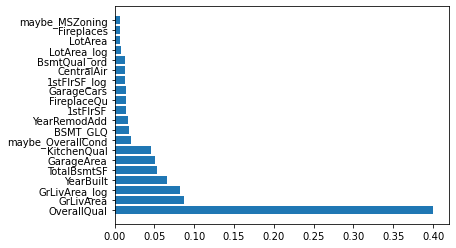

In [17]:
temp = feature_importance.iloc[:20,]
plt.barh(temp["Features"], temp["Importance"]);

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, ylog, test_size=0.3, random_state=0);


GBR.fit(x_train, y_train);

In [19]:
print("The super overfitting train score: %.4f" %GBR.score(x_train, y_train));
print("The super screwed up test score:   %.4f" %GBR.score(x_test, y_test));

The super overfitting train score: 0.9606
The super screwed up test score:   0.9022


### Using GridSearchCV to tune the Gradient boost model...

Much is not completed; had a bit difficulty to get to a set of coefficient much better than the original.

Need more investigation. Maybe a random search strategy. (How?)

In [20]:
from sklearn.model_selection import GridSearchCV;

grid_para_GBR = {"n_estimators": range(50,175,25),
"min_samples_leaf": range(1,10),
"min_samples_split": range(2,20,3),
"max_features": [10, 30, 50, 70, 94],
"max_depth": range(3,24,3)};

grid_search_GBR = GridSearchCV(GBR, grid_para_GBR, scoring = "r2", cv=5, n_jobs=-1);
%time grid_search_GBR.fit(x_train, y_train)

Wall time: 2h 44min 33s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 24, 3),
                         'max_features': [10, 30, 50, 70, 94],
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 20, 3),
                         'n_estimators': range(50, 175, 25)},
             scoring='r2')

In [22]:
best_GBR = grid_search_GBR.best_estimator_


In [1]:
best_GBR.score(x_test, y_test)


NameError: name 'best_GBR' is not defined

In [27]:
best_GBR.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': 30,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 14,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [19]:
# Load from the previous GridSearchCV results
best_GBR = ensemble.GradientBoostingRegressor();
best_GBR.set_params(max_depth=3, max_features=30, min_samples_leaf=5, min_samples_split=14, n_estimators=150, random_state=0);

In [20]:
best_GBR.fit(x_train, y_train);
print(best_GBR.score(x_train, y_train));
print(best_GBR.score(x_test, y_test));

0.9622464664883648
0.9069377830019907


### Cat boost meow

In [2]:
from catboost import Pool, CatBoostRegressor;

cat = CatBoostRegressor();

In [22]:
cat.set_params(random_state=0);
cat.fit(x_train, y_train);

Learning rate set to 0.043361
0:	learn: 0.1616805	total: 173ms	remaining: 2m 52s
1:	learn: 0.1570805	total: 180ms	remaining: 1m 29s
2:	learn: 0.1528213	total: 186ms	remaining: 1m 1s
3:	learn: 0.1484507	total: 191ms	remaining: 47.5s
4:	learn: 0.1442666	total: 195ms	remaining: 38.8s
5:	learn: 0.1403615	total: 198ms	remaining: 32.8s
6:	learn: 0.1366707	total: 201ms	remaining: 28.5s
7:	learn: 0.1330205	total: 204ms	remaining: 25.3s
8:	learn: 0.1299677	total: 206ms	remaining: 22.7s
9:	learn: 0.1267363	total: 209ms	remaining: 20.7s
10:	learn: 0.1233852	total: 212ms	remaining: 19s
11:	learn: 0.1206622	total: 214ms	remaining: 17.6s
12:	learn: 0.1179254	total: 217ms	remaining: 16.4s
13:	learn: 0.1151479	total: 219ms	remaining: 15.4s
14:	learn: 0.1123155	total: 222ms	remaining: 14.6s
15:	learn: 0.1097087	total: 225ms	remaining: 13.8s
16:	learn: 0.1070673	total: 228ms	remaining: 13.2s
17:	learn: 0.1044823	total: 230ms	remaining: 12.5s
18:	learn: 0.1021715	total: 232ms	remaining: 12s
19:	learn: 0.

166:	learn: 0.0393362	total: 541ms	remaining: 2.7s
167:	learn: 0.0393006	total: 544ms	remaining: 2.69s
168:	learn: 0.0392182	total: 546ms	remaining: 2.68s
169:	learn: 0.0391486	total: 548ms	remaining: 2.67s
170:	learn: 0.0391024	total: 550ms	remaining: 2.67s
171:	learn: 0.0390369	total: 552ms	remaining: 2.66s
172:	learn: 0.0389977	total: 554ms	remaining: 2.65s
173:	learn: 0.0389442	total: 556ms	remaining: 2.64s
174:	learn: 0.0388691	total: 558ms	remaining: 2.63s
175:	learn: 0.0387994	total: 561ms	remaining: 2.62s
176:	learn: 0.0387446	total: 563ms	remaining: 2.62s
177:	learn: 0.0386342	total: 565ms	remaining: 2.61s
178:	learn: 0.0385624	total: 567ms	remaining: 2.6s
179:	learn: 0.0385046	total: 570ms	remaining: 2.6s
180:	learn: 0.0384020	total: 572ms	remaining: 2.59s
181:	learn: 0.0383388	total: 574ms	remaining: 2.58s
182:	learn: 0.0382907	total: 577ms	remaining: 2.57s
183:	learn: 0.0382550	total: 579ms	remaining: 2.57s
184:	learn: 0.0381485	total: 581ms	remaining: 2.56s
185:	learn: 0.0

336:	learn: 0.0304224	total: 897ms	remaining: 1.76s
337:	learn: 0.0303761	total: 899ms	remaining: 1.76s
338:	learn: 0.0303455	total: 902ms	remaining: 1.76s
339:	learn: 0.0303074	total: 904ms	remaining: 1.75s
340:	learn: 0.0302787	total: 906ms	remaining: 1.75s
341:	learn: 0.0302409	total: 908ms	remaining: 1.75s
342:	learn: 0.0301838	total: 910ms	remaining: 1.74s
343:	learn: 0.0301727	total: 913ms	remaining: 1.74s
344:	learn: 0.0301438	total: 915ms	remaining: 1.74s
345:	learn: 0.0301122	total: 917ms	remaining: 1.73s
346:	learn: 0.0300813	total: 919ms	remaining: 1.73s
347:	learn: 0.0300352	total: 922ms	remaining: 1.73s
348:	learn: 0.0300097	total: 924ms	remaining: 1.72s
349:	learn: 0.0299799	total: 926ms	remaining: 1.72s
350:	learn: 0.0299676	total: 928ms	remaining: 1.72s
351:	learn: 0.0299124	total: 930ms	remaining: 1.71s
352:	learn: 0.0298785	total: 932ms	remaining: 1.71s
353:	learn: 0.0298422	total: 934ms	remaining: 1.7s
354:	learn: 0.0297761	total: 936ms	remaining: 1.7s
355:	learn: 0.

504:	learn: 0.0248442	total: 1.25s	remaining: 1.23s
505:	learn: 0.0248160	total: 1.26s	remaining: 1.23s
506:	learn: 0.0247897	total: 1.26s	remaining: 1.22s
507:	learn: 0.0247638	total: 1.26s	remaining: 1.22s
508:	learn: 0.0247373	total: 1.26s	remaining: 1.22s
509:	learn: 0.0247021	total: 1.26s	remaining: 1.22s
510:	learn: 0.0246777	total: 1.27s	remaining: 1.21s
511:	learn: 0.0246746	total: 1.27s	remaining: 1.21s
512:	learn: 0.0246527	total: 1.27s	remaining: 1.21s
513:	learn: 0.0246285	total: 1.27s	remaining: 1.2s
514:	learn: 0.0245816	total: 1.28s	remaining: 1.2s
515:	learn: 0.0245783	total: 1.28s	remaining: 1.2s
516:	learn: 0.0245370	total: 1.28s	remaining: 1.2s
517:	learn: 0.0245158	total: 1.28s	remaining: 1.19s
518:	learn: 0.0244832	total: 1.28s	remaining: 1.19s
519:	learn: 0.0244520	total: 1.29s	remaining: 1.19s
520:	learn: 0.0244490	total: 1.29s	remaining: 1.19s
521:	learn: 0.0244145	total: 1.29s	remaining: 1.18s
522:	learn: 0.0243872	total: 1.29s	remaining: 1.18s
523:	learn: 0.02

669:	learn: 0.0210870	total: 1.61s	remaining: 794ms
670:	learn: 0.0210615	total: 1.61s	remaining: 792ms
671:	learn: 0.0210321	total: 1.62s	remaining: 789ms
672:	learn: 0.0210277	total: 1.62s	remaining: 787ms
673:	learn: 0.0210070	total: 1.62s	remaining: 784ms
674:	learn: 0.0209956	total: 1.62s	remaining: 782ms
675:	learn: 0.0209774	total: 1.63s	remaining: 779ms
676:	learn: 0.0209407	total: 1.63s	remaining: 777ms
677:	learn: 0.0209128	total: 1.63s	remaining: 774ms
678:	learn: 0.0208947	total: 1.63s	remaining: 772ms
679:	learn: 0.0208746	total: 1.63s	remaining: 769ms
680:	learn: 0.0208570	total: 1.64s	remaining: 767ms
681:	learn: 0.0208283	total: 1.64s	remaining: 765ms
682:	learn: 0.0207986	total: 1.64s	remaining: 762ms
683:	learn: 0.0207728	total: 1.64s	remaining: 760ms
684:	learn: 0.0207397	total: 1.65s	remaining: 757ms
685:	learn: 0.0207239	total: 1.65s	remaining: 755ms
686:	learn: 0.0207160	total: 1.65s	remaining: 752ms
687:	learn: 0.0206944	total: 1.65s	remaining: 750ms
688:	learn: 

894:	learn: 0.0171207	total: 2.14s	remaining: 252ms
895:	learn: 0.0171102	total: 2.15s	remaining: 249ms
896:	learn: 0.0170886	total: 2.15s	remaining: 247ms
897:	learn: 0.0170744	total: 2.15s	remaining: 244ms
898:	learn: 0.0170542	total: 2.15s	remaining: 242ms
899:	learn: 0.0170388	total: 2.15s	remaining: 239ms
900:	learn: 0.0170209	total: 2.16s	remaining: 237ms
901:	learn: 0.0170103	total: 2.16s	remaining: 235ms
902:	learn: 0.0169988	total: 2.16s	remaining: 232ms
903:	learn: 0.0169853	total: 2.16s	remaining: 230ms
904:	learn: 0.0169630	total: 2.17s	remaining: 227ms
905:	learn: 0.0169349	total: 2.17s	remaining: 225ms
906:	learn: 0.0169247	total: 2.17s	remaining: 223ms
907:	learn: 0.0169158	total: 2.17s	remaining: 220ms
908:	learn: 0.0168913	total: 2.17s	remaining: 218ms
909:	learn: 0.0168905	total: 2.18s	remaining: 215ms
910:	learn: 0.0168755	total: 2.18s	remaining: 213ms
911:	learn: 0.0168615	total: 2.18s	remaining: 210ms
912:	learn: 0.0168451	total: 2.18s	remaining: 208ms
913:	learn: 

In [45]:
print(cat.score(x_train, y_train));
print(cat.score(x_test, y_test)); # Best in the congress so far. 0.9139

0.990931809230831
0.9138660075031821


In [25]:
pred_train = cat.predict(x_train);
pred_test = cat.predict(x_test);

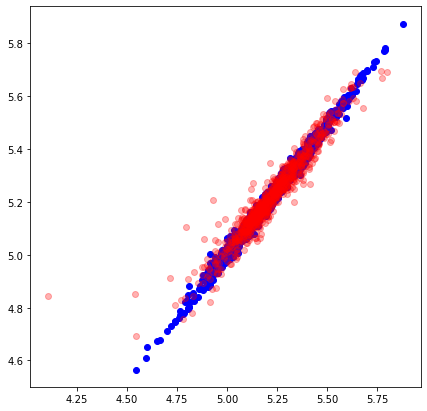

In [30]:
from matplotlib.pyplot import figure;

figure(figsize=(7,7));
plt.scatter(y_train, pred_train, color = 'b');
plt.scatter(y_test, pred_test, color = 'r', alpha=0.3);
plt.show();

In [40]:
# Can we extract the feature importance of a cat booster?
feature_importance = pd.DataFrame({"Features": x.columns, "Importance":cat.feature_importances_});
feature_importance.sort_values("Importance", ascending = False, inplace=True);

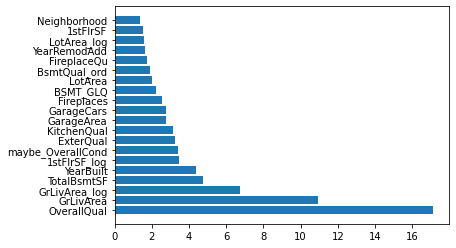

In [41]:
temp = feature_importance.iloc[:20,]
plt.barh(temp["Features"], temp["Importance"]);

### XGBoost

In [51]:
import xgboost as xgb;

xgb_regressor = xgb.XGBRegressor();
xgb_regressor.set_params(random_state=0);
xgb_regressor.fit(x_train, y_train);

print(xgb_regressor.score(x_train, y_train));
print(xgb_regressor.score(x_test, y_test)); # 0.8902

0.9986761756549664
0.8902101348812272


In [52]:
# Can we extract the feature importance of a cat booster?
feature_importance = pd.DataFrame({"Features": x.columns, "Importance":xgb_regressor.feature_importances_});
feature_importance.sort_values("Importance", ascending = False, inplace=True);

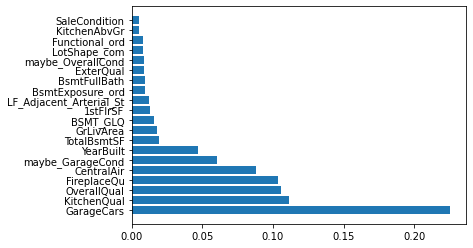

In [53]:
temp = feature_importance.iloc[:20,]
plt.barh(temp["Features"], temp["Importance"]);

### Light GBM regressor

In [55]:
import lightgbm as lgb;

lgb_regressor = lgb.LGBMRegressor();
lgb_regressor.set_params(random_state=0);
lgb_regressor.fit(x_train, y_train);

print(lgb_regressor.score(x_train, y_train));
print(lgb_regressor.score(x_test, y_test)); # 0.904

0.9882591511437923
0.9041122658722386


In [56]:
# Can we extract the feature importance of a cat booster?
feature_importance = pd.DataFrame({"Features": x.columns, "Importance":lgb_regressor.feature_importances_});
feature_importance.sort_values("Importance", ascending = False, inplace=True);

In [60]:
feature_importance["Importance"] = feature_importance["Importance"]/np.sum(feature_importance["Importance"]); # 3000?

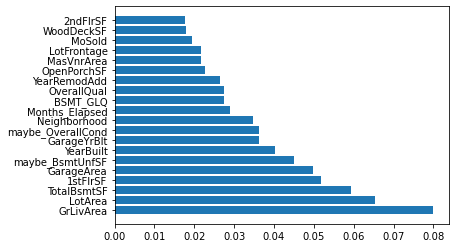

In [61]:
temp = feature_importance.iloc[:20,]
plt.barh(temp["Features"], temp["Importance"]);

### Stacking the predictors

In [65]:
from sklearn.ensemble import RandomForestRegressor;
from sklearn.ensemble import StackingRegressor;

estimators = [
    ("rf", ensemble.RandomForestRegressor(random_state=0)),
    ("gbr", ensemble.GradientBoostingRegressor(random_state=0)),
    ("cat", CatBoostRegressor(random_state=0)),
    ("xgb", xgb.XGBRegressor(random_state=0)),
    ("lgb", lgb.LGBMRegressor(random_state=0))
];
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=0));

In [66]:
reg.fit(x_train, y_train);
print(reg.score(x_train, y_train)); # 0.9674
print(reg.score(x_test, y_test)); # 0.9084


Learning rate set to 0.043361
0:	learn: 0.1616805	total: 3.33ms	remaining: 3.32s
1:	learn: 0.1570805	total: 6.24ms	remaining: 3.12s
2:	learn: 0.1528213	total: 8.81ms	remaining: 2.93s
3:	learn: 0.1484507	total: 11.5ms	remaining: 2.87s
4:	learn: 0.1442666	total: 14.2ms	remaining: 2.83s
5:	learn: 0.1403615	total: 16.8ms	remaining: 2.79s
6:	learn: 0.1366707	total: 19.6ms	remaining: 2.77s
7:	learn: 0.1330205	total: 22.1ms	remaining: 2.74s
8:	learn: 0.1299677	total: 24.9ms	remaining: 2.74s
9:	learn: 0.1267363	total: 27.8ms	remaining: 2.75s
10:	learn: 0.1233852	total: 30.4ms	remaining: 2.73s
11:	learn: 0.1206622	total: 33ms	remaining: 2.71s
12:	learn: 0.1179254	total: 35.6ms	remaining: 2.7s
13:	learn: 0.1151479	total: 38.1ms	remaining: 2.68s
14:	learn: 0.1123155	total: 40.6ms	remaining: 2.67s
15:	learn: 0.1097087	total: 43.2ms	remaining: 2.65s
16:	learn: 0.1070673	total: 45.6ms	remaining: 2.63s
17:	learn: 0.1044823	total: 48.1ms	remaining: 2.63s
18:	learn: 0.1021715	total: 50.7ms	remaining: 2

161:	learn: 0.0397460	total: 365ms	remaining: 1.89s
162:	learn: 0.0396350	total: 368ms	remaining: 1.89s
163:	learn: 0.0395616	total: 370ms	remaining: 1.88s
164:	learn: 0.0394867	total: 372ms	remaining: 1.88s
165:	learn: 0.0393991	total: 374ms	remaining: 1.88s
166:	learn: 0.0393362	total: 376ms	remaining: 1.88s
167:	learn: 0.0393006	total: 379ms	remaining: 1.87s
168:	learn: 0.0392182	total: 381ms	remaining: 1.87s
169:	learn: 0.0391486	total: 383ms	remaining: 1.87s
170:	learn: 0.0391024	total: 385ms	remaining: 1.87s
171:	learn: 0.0390369	total: 387ms	remaining: 1.86s
172:	learn: 0.0389977	total: 390ms	remaining: 1.86s
173:	learn: 0.0389442	total: 392ms	remaining: 1.86s
174:	learn: 0.0388691	total: 394ms	remaining: 1.86s
175:	learn: 0.0387994	total: 397ms	remaining: 1.86s
176:	learn: 0.0387446	total: 399ms	remaining: 1.86s
177:	learn: 0.0386342	total: 402ms	remaining: 1.85s
178:	learn: 0.0385624	total: 404ms	remaining: 1.85s
179:	learn: 0.0385046	total: 406ms	remaining: 1.85s
180:	learn: 

335:	learn: 0.0304698	total: 735ms	remaining: 1.45s
336:	learn: 0.0304224	total: 737ms	remaining: 1.45s
337:	learn: 0.0303761	total: 739ms	remaining: 1.45s
338:	learn: 0.0303455	total: 742ms	remaining: 1.45s
339:	learn: 0.0303074	total: 744ms	remaining: 1.44s
340:	learn: 0.0302787	total: 746ms	remaining: 1.44s
341:	learn: 0.0302409	total: 748ms	remaining: 1.44s
342:	learn: 0.0301838	total: 750ms	remaining: 1.44s
343:	learn: 0.0301727	total: 753ms	remaining: 1.44s
344:	learn: 0.0301438	total: 755ms	remaining: 1.43s
345:	learn: 0.0301122	total: 757ms	remaining: 1.43s
346:	learn: 0.0300813	total: 760ms	remaining: 1.43s
347:	learn: 0.0300352	total: 762ms	remaining: 1.43s
348:	learn: 0.0300097	total: 764ms	remaining: 1.43s
349:	learn: 0.0299799	total: 766ms	remaining: 1.42s
350:	learn: 0.0299676	total: 768ms	remaining: 1.42s
351:	learn: 0.0299124	total: 770ms	remaining: 1.42s
352:	learn: 0.0298785	total: 772ms	remaining: 1.42s
353:	learn: 0.0298422	total: 775ms	remaining: 1.41s
354:	learn: 

505:	learn: 0.0248160	total: 1.09s	remaining: 1.06s
506:	learn: 0.0247897	total: 1.09s	remaining: 1.06s
507:	learn: 0.0247638	total: 1.1s	remaining: 1.06s
508:	learn: 0.0247373	total: 1.1s	remaining: 1.06s
509:	learn: 0.0247021	total: 1.1s	remaining: 1.06s
510:	learn: 0.0246777	total: 1.1s	remaining: 1.05s
511:	learn: 0.0246746	total: 1.1s	remaining: 1.05s
512:	learn: 0.0246527	total: 1.11s	remaining: 1.05s
513:	learn: 0.0246285	total: 1.11s	remaining: 1.05s
514:	learn: 0.0245816	total: 1.11s	remaining: 1.05s
515:	learn: 0.0245783	total: 1.11s	remaining: 1.04s
516:	learn: 0.0245370	total: 1.12s	remaining: 1.04s
517:	learn: 0.0245158	total: 1.12s	remaining: 1.04s
518:	learn: 0.0244832	total: 1.12s	remaining: 1.04s
519:	learn: 0.0244520	total: 1.12s	remaining: 1.04s
520:	learn: 0.0244490	total: 1.12s	remaining: 1.03s
521:	learn: 0.0244145	total: 1.13s	remaining: 1.03s
522:	learn: 0.0243872	total: 1.13s	remaining: 1.03s
523:	learn: 0.0243822	total: 1.13s	remaining: 1.03s
524:	learn: 0.024

674:	learn: 0.0209956	total: 1.45s	remaining: 696ms
675:	learn: 0.0209774	total: 1.45s	remaining: 694ms
676:	learn: 0.0209407	total: 1.45s	remaining: 692ms
677:	learn: 0.0209128	total: 1.45s	remaining: 690ms
678:	learn: 0.0208947	total: 1.46s	remaining: 688ms
679:	learn: 0.0208746	total: 1.46s	remaining: 686ms
680:	learn: 0.0208570	total: 1.46s	remaining: 684ms
681:	learn: 0.0208283	total: 1.46s	remaining: 682ms
682:	learn: 0.0207986	total: 1.46s	remaining: 680ms
683:	learn: 0.0207728	total: 1.47s	remaining: 678ms
684:	learn: 0.0207397	total: 1.47s	remaining: 675ms
685:	learn: 0.0207239	total: 1.47s	remaining: 673ms
686:	learn: 0.0207160	total: 1.47s	remaining: 671ms
687:	learn: 0.0206944	total: 1.48s	remaining: 669ms
688:	learn: 0.0206902	total: 1.48s	remaining: 667ms
689:	learn: 0.0206622	total: 1.48s	remaining: 665ms
690:	learn: 0.0206433	total: 1.48s	remaining: 663ms
691:	learn: 0.0206210	total: 1.48s	remaining: 660ms
692:	learn: 0.0206051	total: 1.49s	remaining: 658ms
693:	learn: 

843:	learn: 0.0179185	total: 1.8s	remaining: 333ms
844:	learn: 0.0179043	total: 1.8s	remaining: 331ms
845:	learn: 0.0178909	total: 1.81s	remaining: 329ms
846:	learn: 0.0178807	total: 1.81s	remaining: 327ms
847:	learn: 0.0178583	total: 1.81s	remaining: 325ms
848:	learn: 0.0178420	total: 1.81s	remaining: 323ms
849:	learn: 0.0178187	total: 1.81s	remaining: 320ms
850:	learn: 0.0177975	total: 1.82s	remaining: 318ms
851:	learn: 0.0177709	total: 1.82s	remaining: 316ms
852:	learn: 0.0177573	total: 1.82s	remaining: 314ms
853:	learn: 0.0177316	total: 1.82s	remaining: 312ms
854:	learn: 0.0177186	total: 1.83s	remaining: 310ms
855:	learn: 0.0176955	total: 1.83s	remaining: 308ms
856:	learn: 0.0176879	total: 1.83s	remaining: 306ms
857:	learn: 0.0176761	total: 1.83s	remaining: 303ms
858:	learn: 0.0176641	total: 1.83s	remaining: 301ms
859:	learn: 0.0176476	total: 1.84s	remaining: 299ms
860:	learn: 0.0176326	total: 1.84s	remaining: 297ms
861:	learn: 0.0176187	total: 1.84s	remaining: 295ms
862:	learn: 0.

57:	learn: 0.0595677	total: 166ms	remaining: 2.69s
58:	learn: 0.0591067	total: 168ms	remaining: 2.68s
59:	learn: 0.0585134	total: 170ms	remaining: 2.66s
60:	learn: 0.0580018	total: 172ms	remaining: 2.65s
61:	learn: 0.0575152	total: 174ms	remaining: 2.63s
62:	learn: 0.0570532	total: 176ms	remaining: 2.62s
63:	learn: 0.0565925	total: 178ms	remaining: 2.61s
64:	learn: 0.0561239	total: 180ms	remaining: 2.6s
65:	learn: 0.0556596	total: 182ms	remaining: 2.58s
66:	learn: 0.0552554	total: 185ms	remaining: 2.57s
67:	learn: 0.0548301	total: 187ms	remaining: 2.56s
68:	learn: 0.0545233	total: 189ms	remaining: 2.55s
69:	learn: 0.0541503	total: 191ms	remaining: 2.54s
70:	learn: 0.0538372	total: 194ms	remaining: 2.54s
71:	learn: 0.0534907	total: 196ms	remaining: 2.53s
72:	learn: 0.0530929	total: 198ms	remaining: 2.52s
73:	learn: 0.0528074	total: 201ms	remaining: 2.51s
74:	learn: 0.0524821	total: 203ms	remaining: 2.5s
75:	learn: 0.0521432	total: 205ms	remaining: 2.49s
76:	learn: 0.0518184	total: 207ms

231:	learn: 0.0351662	total: 524ms	remaining: 1.74s
232:	learn: 0.0351080	total: 527ms	remaining: 1.73s
233:	learn: 0.0350362	total: 529ms	remaining: 1.73s
234:	learn: 0.0349816	total: 531ms	remaining: 1.73s
235:	learn: 0.0349372	total: 533ms	remaining: 1.72s
236:	learn: 0.0348597	total: 535ms	remaining: 1.72s
237:	learn: 0.0348015	total: 537ms	remaining: 1.72s
238:	learn: 0.0347550	total: 539ms	remaining: 1.71s
239:	learn: 0.0346644	total: 541ms	remaining: 1.71s
240:	learn: 0.0345843	total: 543ms	remaining: 1.71s
241:	learn: 0.0345125	total: 545ms	remaining: 1.71s
242:	learn: 0.0344749	total: 547ms	remaining: 1.7s
243:	learn: 0.0344255	total: 549ms	remaining: 1.7s
244:	learn: 0.0343465	total: 551ms	remaining: 1.7s
245:	learn: 0.0343054	total: 553ms	remaining: 1.7s
246:	learn: 0.0342440	total: 555ms	remaining: 1.69s
247:	learn: 0.0341980	total: 557ms	remaining: 1.69s
248:	learn: 0.0341309	total: 559ms	remaining: 1.69s
249:	learn: 0.0340697	total: 561ms	remaining: 1.68s
250:	learn: 0.03

406:	learn: 0.0268270	total: 881ms	remaining: 1.28s
407:	learn: 0.0267924	total: 884ms	remaining: 1.28s
408:	learn: 0.0267415	total: 886ms	remaining: 1.28s
409:	learn: 0.0267009	total: 888ms	remaining: 1.28s
410:	learn: 0.0266495	total: 890ms	remaining: 1.27s
411:	learn: 0.0266180	total: 892ms	remaining: 1.27s
412:	learn: 0.0265849	total: 894ms	remaining: 1.27s
413:	learn: 0.0265333	total: 896ms	remaining: 1.27s
414:	learn: 0.0264894	total: 898ms	remaining: 1.27s
415:	learn: 0.0264616	total: 900ms	remaining: 1.26s
416:	learn: 0.0264389	total: 902ms	remaining: 1.26s
417:	learn: 0.0264103	total: 905ms	remaining: 1.26s
418:	learn: 0.0263654	total: 907ms	remaining: 1.26s
419:	learn: 0.0263263	total: 909ms	remaining: 1.25s
420:	learn: 0.0262885	total: 911ms	remaining: 1.25s
421:	learn: 0.0262334	total: 914ms	remaining: 1.25s
422:	learn: 0.0262044	total: 916ms	remaining: 1.25s
423:	learn: 0.0261686	total: 918ms	remaining: 1.25s
424:	learn: 0.0261332	total: 920ms	remaining: 1.24s
425:	learn: 

573:	learn: 0.0218022	total: 1.24s	remaining: 919ms
574:	learn: 0.0217790	total: 1.24s	remaining: 917ms
575:	learn: 0.0217305	total: 1.24s	remaining: 915ms
576:	learn: 0.0217049	total: 1.25s	remaining: 913ms
577:	learn: 0.0216800	total: 1.25s	remaining: 911ms
578:	learn: 0.0216497	total: 1.25s	remaining: 909ms
579:	learn: 0.0216157	total: 1.25s	remaining: 907ms
580:	learn: 0.0215885	total: 1.25s	remaining: 904ms
581:	learn: 0.0215691	total: 1.26s	remaining: 902ms
582:	learn: 0.0215648	total: 1.26s	remaining: 900ms
583:	learn: 0.0215276	total: 1.26s	remaining: 898ms
584:	learn: 0.0215046	total: 1.26s	remaining: 896ms
585:	learn: 0.0214788	total: 1.26s	remaining: 894ms
586:	learn: 0.0214587	total: 1.27s	remaining: 892ms
587:	learn: 0.0214486	total: 1.27s	remaining: 889ms
588:	learn: 0.0214407	total: 1.27s	remaining: 887ms
589:	learn: 0.0214229	total: 1.27s	remaining: 885ms
590:	learn: 0.0213960	total: 1.27s	remaining: 883ms
591:	learn: 0.0213707	total: 1.28s	remaining: 881ms
592:	learn: 

752:	learn: 0.0179702	total: 1.6s	remaining: 526ms
753:	learn: 0.0179466	total: 1.6s	remaining: 524ms
754:	learn: 0.0179447	total: 1.61s	remaining: 521ms
755:	learn: 0.0179334	total: 1.61s	remaining: 519ms
756:	learn: 0.0179053	total: 1.61s	remaining: 517ms
757:	learn: 0.0178855	total: 1.61s	remaining: 515ms
758:	learn: 0.0178609	total: 1.61s	remaining: 513ms
759:	learn: 0.0178430	total: 1.62s	remaining: 511ms
760:	learn: 0.0178192	total: 1.62s	remaining: 509ms
761:	learn: 0.0177960	total: 1.62s	remaining: 506ms
762:	learn: 0.0177930	total: 1.62s	remaining: 504ms
763:	learn: 0.0177563	total: 1.63s	remaining: 502ms
764:	learn: 0.0177431	total: 1.63s	remaining: 500ms
765:	learn: 0.0177092	total: 1.63s	remaining: 498ms
766:	learn: 0.0176932	total: 1.63s	remaining: 496ms
767:	learn: 0.0176526	total: 1.63s	remaining: 493ms
768:	learn: 0.0176508	total: 1.64s	remaining: 491ms
769:	learn: 0.0176399	total: 1.64s	remaining: 489ms
770:	learn: 0.0176178	total: 1.64s	remaining: 487ms
771:	learn: 0.

932:	learn: 0.0151068	total: 1.95s	remaining: 140ms
933:	learn: 0.0150932	total: 1.96s	remaining: 138ms
934:	learn: 0.0150686	total: 1.96s	remaining: 136ms
935:	learn: 0.0150473	total: 1.96s	remaining: 134ms
936:	learn: 0.0150382	total: 1.96s	remaining: 132ms
937:	learn: 0.0150261	total: 1.96s	remaining: 130ms
938:	learn: 0.0150162	total: 1.97s	remaining: 128ms
939:	learn: 0.0150104	total: 1.97s	remaining: 126ms
940:	learn: 0.0149954	total: 1.97s	remaining: 123ms
941:	learn: 0.0149941	total: 1.97s	remaining: 121ms
942:	learn: 0.0149914	total: 1.97s	remaining: 119ms
943:	learn: 0.0149855	total: 1.98s	remaining: 117ms
944:	learn: 0.0149646	total: 1.98s	remaining: 115ms
945:	learn: 0.0149379	total: 1.98s	remaining: 113ms
946:	learn: 0.0149281	total: 1.98s	remaining: 111ms
947:	learn: 0.0149159	total: 1.98s	remaining: 109ms
948:	learn: 0.0149152	total: 1.99s	remaining: 107ms
949:	learn: 0.0148993	total: 1.99s	remaining: 105ms
950:	learn: 0.0148852	total: 1.99s	remaining: 103ms
951:	learn: 

169:	learn: 0.0389223	total: 358ms	remaining: 1.75s
170:	learn: 0.0388739	total: 360ms	remaining: 1.74s
171:	learn: 0.0387720	total: 362ms	remaining: 1.74s
172:	learn: 0.0387442	total: 364ms	remaining: 1.74s
173:	learn: 0.0386681	total: 366ms	remaining: 1.74s
174:	learn: 0.0386083	total: 368ms	remaining: 1.73s
175:	learn: 0.0385249	total: 370ms	remaining: 1.73s
176:	learn: 0.0384754	total: 372ms	remaining: 1.73s
177:	learn: 0.0384277	total: 374ms	remaining: 1.73s
178:	learn: 0.0383349	total: 376ms	remaining: 1.72s
179:	learn: 0.0383078	total: 378ms	remaining: 1.72s
180:	learn: 0.0382217	total: 380ms	remaining: 1.72s
181:	learn: 0.0381538	total: 383ms	remaining: 1.72s
182:	learn: 0.0381160	total: 385ms	remaining: 1.72s
183:	learn: 0.0380676	total: 387ms	remaining: 1.72s
184:	learn: 0.0379869	total: 389ms	remaining: 1.71s
185:	learn: 0.0379173	total: 391ms	remaining: 1.71s
186:	learn: 0.0378554	total: 393ms	remaining: 1.71s
187:	learn: 0.0377259	total: 395ms	remaining: 1.7s
188:	learn: 0

352:	learn: 0.0295464	total: 713ms	remaining: 1.31s
353:	learn: 0.0294863	total: 715ms	remaining: 1.3s
354:	learn: 0.0294797	total: 717ms	remaining: 1.3s
355:	learn: 0.0294291	total: 719ms	remaining: 1.3s
356:	learn: 0.0293939	total: 721ms	remaining: 1.3s
357:	learn: 0.0293381	total: 723ms	remaining: 1.3s
358:	learn: 0.0293309	total: 725ms	remaining: 1.29s
359:	learn: 0.0292921	total: 727ms	remaining: 1.29s
360:	learn: 0.0292547	total: 729ms	remaining: 1.29s
361:	learn: 0.0292269	total: 731ms	remaining: 1.29s
362:	learn: 0.0291951	total: 734ms	remaining: 1.29s
363:	learn: 0.0291729	total: 736ms	remaining: 1.28s
364:	learn: 0.0291170	total: 738ms	remaining: 1.28s
365:	learn: 0.0290928	total: 740ms	remaining: 1.28s
366:	learn: 0.0290608	total: 742ms	remaining: 1.28s
367:	learn: 0.0290248	total: 744ms	remaining: 1.28s
368:	learn: 0.0290070	total: 746ms	remaining: 1.27s
369:	learn: 0.0289397	total: 748ms	remaining: 1.27s
370:	learn: 0.0289005	total: 750ms	remaining: 1.27s
371:	learn: 0.028

533:	learn: 0.0231398	total: 1.09s	remaining: 955ms
534:	learn: 0.0231110	total: 1.1s	remaining: 953ms
535:	learn: 0.0230881	total: 1.1s	remaining: 952ms
536:	learn: 0.0230675	total: 1.1s	remaining: 950ms
537:	learn: 0.0230508	total: 1.1s	remaining: 947ms
538:	learn: 0.0230238	total: 1.1s	remaining: 945ms
539:	learn: 0.0230048	total: 1.11s	remaining: 943ms
540:	learn: 0.0229731	total: 1.11s	remaining: 941ms
541:	learn: 0.0229589	total: 1.11s	remaining: 940ms
542:	learn: 0.0229379	total: 1.11s	remaining: 938ms
543:	learn: 0.0229186	total: 1.12s	remaining: 936ms
544:	learn: 0.0228866	total: 1.12s	remaining: 934ms
545:	learn: 0.0228501	total: 1.12s	remaining: 932ms
546:	learn: 0.0228092	total: 1.12s	remaining: 930ms
547:	learn: 0.0227991	total: 1.12s	remaining: 928ms
548:	learn: 0.0227961	total: 1.13s	remaining: 926ms
549:	learn: 0.0227712	total: 1.13s	remaining: 924ms
550:	learn: 0.0227302	total: 1.13s	remaining: 922ms
551:	learn: 0.0227106	total: 1.13s	remaining: 920ms
552:	learn: 0.022

708:	learn: 0.0194124	total: 1.46s	remaining: 597ms
709:	learn: 0.0193868	total: 1.46s	remaining: 595ms
710:	learn: 0.0193628	total: 1.46s	remaining: 593ms
711:	learn: 0.0193544	total: 1.46s	remaining: 591ms
712:	learn: 0.0193528	total: 1.46s	remaining: 589ms
713:	learn: 0.0193280	total: 1.47s	remaining: 587ms
714:	learn: 0.0193234	total: 1.47s	remaining: 585ms
715:	learn: 0.0192936	total: 1.47s	remaining: 583ms
716:	learn: 0.0192631	total: 1.47s	remaining: 581ms
717:	learn: 0.0192408	total: 1.47s	remaining: 579ms
718:	learn: 0.0192201	total: 1.48s	remaining: 577ms
719:	learn: 0.0192026	total: 1.48s	remaining: 575ms
720:	learn: 0.0191758	total: 1.48s	remaining: 573ms
721:	learn: 0.0191449	total: 1.48s	remaining: 571ms
722:	learn: 0.0191426	total: 1.49s	remaining: 569ms
723:	learn: 0.0191274	total: 1.49s	remaining: 567ms
724:	learn: 0.0191085	total: 1.49s	remaining: 565ms
725:	learn: 0.0190824	total: 1.49s	remaining: 563ms
726:	learn: 0.0190602	total: 1.49s	remaining: 561ms
727:	learn: 

948:	learn: 0.0153374	total: 1.99s	remaining: 107ms
949:	learn: 0.0153209	total: 1.99s	remaining: 105ms
950:	learn: 0.0153036	total: 1.99s	remaining: 103ms
951:	learn: 0.0152871	total: 2s	remaining: 101ms
952:	learn: 0.0152624	total: 2s	remaining: 98.5ms
953:	learn: 0.0152452	total: 2s	remaining: 96.4ms
954:	learn: 0.0152384	total: 2s	remaining: 94.3ms
955:	learn: 0.0152208	total: 2s	remaining: 92.3ms
956:	learn: 0.0151997	total: 2.01s	remaining: 90.2ms
957:	learn: 0.0151771	total: 2.01s	remaining: 88.1ms
958:	learn: 0.0151458	total: 2.01s	remaining: 86ms
959:	learn: 0.0151347	total: 2.01s	remaining: 83.9ms
960:	learn: 0.0151162	total: 2.02s	remaining: 81.8ms
961:	learn: 0.0151011	total: 2.02s	remaining: 79.7ms
962:	learn: 0.0150993	total: 2.02s	remaining: 77.6ms
963:	learn: 0.0150881	total: 2.02s	remaining: 75.5ms
964:	learn: 0.0150795	total: 2.02s	remaining: 73.4ms
965:	learn: 0.0150571	total: 2.02s	remaining: 71.3ms
966:	learn: 0.0150469	total: 2.03s	remaining: 69.2ms
967:	learn: 0.

154:	learn: 0.0412069	total: 367ms	remaining: 2s
155:	learn: 0.0411247	total: 369ms	remaining: 2s
156:	learn: 0.0410660	total: 371ms	remaining: 1.99s
157:	learn: 0.0410227	total: 374ms	remaining: 1.99s
158:	learn: 0.0409419	total: 376ms	remaining: 1.99s
159:	learn: 0.0408692	total: 379ms	remaining: 1.99s
160:	learn: 0.0407812	total: 381ms	remaining: 1.99s
161:	learn: 0.0406972	total: 383ms	remaining: 1.98s
162:	learn: 0.0406001	total: 385ms	remaining: 1.98s
163:	learn: 0.0405470	total: 388ms	remaining: 1.98s
164:	learn: 0.0404950	total: 391ms	remaining: 1.98s
165:	learn: 0.0404446	total: 393ms	remaining: 1.98s
166:	learn: 0.0403684	total: 395ms	remaining: 1.97s
167:	learn: 0.0403139	total: 397ms	remaining: 1.97s
168:	learn: 0.0402015	total: 399ms	remaining: 1.96s
169:	learn: 0.0400972	total: 402ms	remaining: 1.96s
170:	learn: 0.0400665	total: 404ms	remaining: 1.96s
171:	learn: 0.0400024	total: 406ms	remaining: 1.96s
172:	learn: 0.0399172	total: 409ms	remaining: 1.95s
173:	learn: 0.0398

320:	learn: 0.0312954	total: 722ms	remaining: 1.53s
321:	learn: 0.0312322	total: 724ms	remaining: 1.52s
322:	learn: 0.0311907	total: 726ms	remaining: 1.52s
323:	learn: 0.0311370	total: 728ms	remaining: 1.52s
324:	learn: 0.0310890	total: 730ms	remaining: 1.51s
325:	learn: 0.0310791	total: 732ms	remaining: 1.51s
326:	learn: 0.0310380	total: 734ms	remaining: 1.51s
327:	learn: 0.0310122	total: 736ms	remaining: 1.51s
328:	learn: 0.0309637	total: 738ms	remaining: 1.5s
329:	learn: 0.0308995	total: 740ms	remaining: 1.5s
330:	learn: 0.0308596	total: 742ms	remaining: 1.5s
331:	learn: 0.0308084	total: 744ms	remaining: 1.5s
332:	learn: 0.0307279	total: 746ms	remaining: 1.49s
333:	learn: 0.0306866	total: 749ms	remaining: 1.49s
334:	learn: 0.0306329	total: 751ms	remaining: 1.49s
335:	learn: 0.0305828	total: 753ms	remaining: 1.49s
336:	learn: 0.0305115	total: 756ms	remaining: 1.49s
337:	learn: 0.0304677	total: 758ms	remaining: 1.48s
338:	learn: 0.0304240	total: 760ms	remaining: 1.48s
339:	learn: 0.03

495:	learn: 0.0249886	total: 1.08s	remaining: 1.1s
496:	learn: 0.0249557	total: 1.08s	remaining: 1.09s
497:	learn: 0.0249269	total: 1.08s	remaining: 1.09s
498:	learn: 0.0249030	total: 1.08s	remaining: 1.09s
499:	learn: 0.0248515	total: 1.09s	remaining: 1.09s
500:	learn: 0.0248018	total: 1.09s	remaining: 1.09s
501:	learn: 0.0247893	total: 1.09s	remaining: 1.08s
502:	learn: 0.0247548	total: 1.09s	remaining: 1.08s
503:	learn: 0.0247361	total: 1.1s	remaining: 1.08s
504:	learn: 0.0246819	total: 1.1s	remaining: 1.08s
505:	learn: 0.0246579	total: 1.1s	remaining: 1.07s
506:	learn: 0.0246306	total: 1.1s	remaining: 1.07s
507:	learn: 0.0245942	total: 1.11s	remaining: 1.07s
508:	learn: 0.0245398	total: 1.11s	remaining: 1.07s
509:	learn: 0.0245015	total: 1.11s	remaining: 1.07s
510:	learn: 0.0244688	total: 1.11s	remaining: 1.06s
511:	learn: 0.0244250	total: 1.11s	remaining: 1.06s
512:	learn: 0.0243937	total: 1.12s	remaining: 1.06s
513:	learn: 0.0243632	total: 1.12s	remaining: 1.06s
514:	learn: 0.024

669:	learn: 0.0205304	total: 1.44s	remaining: 707ms
670:	learn: 0.0205046	total: 1.44s	remaining: 705ms
671:	learn: 0.0204784	total: 1.44s	remaining: 703ms
672:	learn: 0.0204678	total: 1.44s	remaining: 701ms
673:	learn: 0.0204344	total: 1.44s	remaining: 699ms
674:	learn: 0.0204015	total: 1.45s	remaining: 697ms
675:	learn: 0.0203738	total: 1.45s	remaining: 694ms
676:	learn: 0.0203492	total: 1.45s	remaining: 692ms
677:	learn: 0.0203261	total: 1.45s	remaining: 690ms
678:	learn: 0.0203178	total: 1.46s	remaining: 688ms
679:	learn: 0.0202923	total: 1.46s	remaining: 686ms
680:	learn: 0.0202728	total: 1.46s	remaining: 684ms
681:	learn: 0.0202465	total: 1.46s	remaining: 682ms
682:	learn: 0.0202193	total: 1.46s	remaining: 680ms
683:	learn: 0.0202158	total: 1.47s	remaining: 678ms
684:	learn: 0.0202002	total: 1.47s	remaining: 676ms
685:	learn: 0.0201821	total: 1.47s	remaining: 674ms
686:	learn: 0.0201400	total: 1.47s	remaining: 672ms
687:	learn: 0.0201359	total: 1.48s	remaining: 670ms
688:	learn: 

901:	learn: 0.0165041	total: 1.96s	remaining: 213ms
902:	learn: 0.0164897	total: 1.97s	remaining: 211ms
903:	learn: 0.0164885	total: 1.97s	remaining: 209ms
904:	learn: 0.0164685	total: 1.97s	remaining: 207ms
905:	learn: 0.0164554	total: 1.97s	remaining: 205ms
906:	learn: 0.0164487	total: 1.98s	remaining: 203ms
907:	learn: 0.0164235	total: 1.98s	remaining: 200ms
908:	learn: 0.0164176	total: 1.98s	remaining: 198ms
909:	learn: 0.0163935	total: 1.98s	remaining: 196ms
910:	learn: 0.0163773	total: 1.99s	remaining: 194ms
911:	learn: 0.0163627	total: 1.99s	remaining: 192ms
912:	learn: 0.0163371	total: 1.99s	remaining: 190ms
913:	learn: 0.0163200	total: 1.99s	remaining: 187ms
914:	learn: 0.0163192	total: 1.99s	remaining: 185ms
915:	learn: 0.0162957	total: 2s	remaining: 183ms
916:	learn: 0.0162860	total: 2s	remaining: 181ms
917:	learn: 0.0162631	total: 2s	remaining: 179ms
918:	learn: 0.0162468	total: 2s	remaining: 176ms
919:	learn: 0.0162228	total: 2s	remaining: 174ms
920:	learn: 0.0162032	total

105:	learn: 0.0454513	total: 243ms	remaining: 2.05s
106:	learn: 0.0452869	total: 245ms	remaining: 2.04s
107:	learn: 0.0451381	total: 247ms	remaining: 2.04s
108:	learn: 0.0449875	total: 249ms	remaining: 2.04s
109:	learn: 0.0448428	total: 252ms	remaining: 2.04s
110:	learn: 0.0446645	total: 254ms	remaining: 2.03s
111:	learn: 0.0445281	total: 256ms	remaining: 2.03s
112:	learn: 0.0443615	total: 258ms	remaining: 2.03s
113:	learn: 0.0441722	total: 261ms	remaining: 2.03s
114:	learn: 0.0440175	total: 263ms	remaining: 2.02s
115:	learn: 0.0438400	total: 266ms	remaining: 2.02s
116:	learn: 0.0437313	total: 268ms	remaining: 2.02s
117:	learn: 0.0436091	total: 270ms	remaining: 2.02s
118:	learn: 0.0435016	total: 272ms	remaining: 2.01s
119:	learn: 0.0433844	total: 274ms	remaining: 2.01s
120:	learn: 0.0432629	total: 296ms	remaining: 2.15s
121:	learn: 0.0431138	total: 304ms	remaining: 2.19s
122:	learn: 0.0429466	total: 311ms	remaining: 2.22s
123:	learn: 0.0428452	total: 317ms	remaining: 2.24s
124:	learn: 

327:	learn: 0.0296818	total: 775ms	remaining: 1.59s
328:	learn: 0.0296389	total: 777ms	remaining: 1.58s
329:	learn: 0.0296099	total: 779ms	remaining: 1.58s
330:	learn: 0.0295521	total: 781ms	remaining: 1.58s
331:	learn: 0.0294879	total: 784ms	remaining: 1.58s
332:	learn: 0.0294419	total: 786ms	remaining: 1.57s
333:	learn: 0.0293907	total: 789ms	remaining: 1.57s
334:	learn: 0.0293567	total: 791ms	remaining: 1.57s
335:	learn: 0.0292950	total: 793ms	remaining: 1.57s
336:	learn: 0.0292664	total: 796ms	remaining: 1.56s
337:	learn: 0.0292155	total: 798ms	remaining: 1.56s
338:	learn: 0.0291705	total: 800ms	remaining: 1.56s
339:	learn: 0.0291245	total: 803ms	remaining: 1.56s
340:	learn: 0.0290965	total: 805ms	remaining: 1.55s
341:	learn: 0.0290855	total: 807ms	remaining: 1.55s
342:	learn: 0.0290536	total: 809ms	remaining: 1.55s
343:	learn: 0.0290150	total: 812ms	remaining: 1.55s
344:	learn: 0.0289759	total: 814ms	remaining: 1.54s
345:	learn: 0.0289361	total: 816ms	remaining: 1.54s
346:	learn: 

564:	learn: 0.0219540	total: 1.3s	remaining: 1s
565:	learn: 0.0219383	total: 1.31s	remaining: 1s
566:	learn: 0.0219289	total: 1.31s	remaining: 999ms
567:	learn: 0.0218950	total: 1.31s	remaining: 997ms
568:	learn: 0.0218734	total: 1.31s	remaining: 994ms
569:	learn: 0.0218476	total: 1.31s	remaining: 992ms
570:	learn: 0.0218048	total: 1.32s	remaining: 989ms
571:	learn: 0.0217650	total: 1.32s	remaining: 987ms
572:	learn: 0.0217582	total: 1.32s	remaining: 984ms
573:	learn: 0.0217560	total: 1.32s	remaining: 982ms
574:	learn: 0.0217254	total: 1.32s	remaining: 979ms
575:	learn: 0.0217177	total: 1.33s	remaining: 977ms
576:	learn: 0.0216805	total: 1.33s	remaining: 975ms
577:	learn: 0.0216618	total: 1.33s	remaining: 972ms
578:	learn: 0.0216279	total: 1.33s	remaining: 970ms
579:	learn: 0.0216125	total: 1.33s	remaining: 967ms
580:	learn: 0.0216091	total: 1.34s	remaining: 964ms
581:	learn: 0.0215787	total: 1.34s	remaining: 962ms
582:	learn: 0.0215476	total: 1.34s	remaining: 959ms
583:	learn: 0.02153

791:	learn: 0.0171366	total: 1.83s	remaining: 481ms
792:	learn: 0.0171193	total: 1.83s	remaining: 479ms
793:	learn: 0.0171058	total: 1.84s	remaining: 476ms
794:	learn: 0.0171041	total: 1.84s	remaining: 474ms
795:	learn: 0.0170875	total: 1.84s	remaining: 472ms
796:	learn: 0.0170651	total: 1.84s	remaining: 469ms
797:	learn: 0.0170475	total: 1.84s	remaining: 467ms
798:	learn: 0.0170461	total: 1.85s	remaining: 465ms
799:	learn: 0.0170254	total: 1.85s	remaining: 462ms
800:	learn: 0.0170237	total: 1.85s	remaining: 460ms
801:	learn: 0.0170203	total: 1.85s	remaining: 458ms
802:	learn: 0.0169981	total: 1.86s	remaining: 456ms
803:	learn: 0.0169743	total: 1.86s	remaining: 453ms
804:	learn: 0.0169586	total: 1.86s	remaining: 451ms
805:	learn: 0.0169452	total: 1.86s	remaining: 449ms
806:	learn: 0.0169439	total: 1.86s	remaining: 446ms
807:	learn: 0.0169283	total: 1.87s	remaining: 444ms
808:	learn: 0.0169054	total: 1.87s	remaining: 441ms
809:	learn: 0.0168805	total: 1.87s	remaining: 439ms
810:	learn: 

0:	learn: 0.1596283	total: 2.61ms	remaining: 2.61s
1:	learn: 0.1553747	total: 4.99ms	remaining: 2.49s
2:	learn: 0.1511980	total: 7.31ms	remaining: 2.43s
3:	learn: 0.1469339	total: 9.52ms	remaining: 2.37s
4:	learn: 0.1432053	total: 12.3ms	remaining: 2.44s
5:	learn: 0.1394538	total: 14.8ms	remaining: 2.46s
6:	learn: 0.1361739	total: 17.5ms	remaining: 2.48s
7:	learn: 0.1327129	total: 20.2ms	remaining: 2.5s
8:	learn: 0.1297862	total: 22.5ms	remaining: 2.48s
9:	learn: 0.1266467	total: 25ms	remaining: 2.48s
10:	learn: 0.1233994	total: 27.7ms	remaining: 2.49s
11:	learn: 0.1207904	total: 30.6ms	remaining: 2.52s
12:	learn: 0.1181641	total: 33.5ms	remaining: 2.54s
13:	learn: 0.1153877	total: 36.5ms	remaining: 2.57s
14:	learn: 0.1126874	total: 39.1ms	remaining: 2.57s
15:	learn: 0.1102754	total: 41.4ms	remaining: 2.55s
16:	learn: 0.1080893	total: 43.7ms	remaining: 2.53s
17:	learn: 0.1058904	total: 46.3ms	remaining: 2.53s
18:	learn: 0.1036466	total: 49ms	remaining: 2.53s
19:	learn: 0.1017107	total:

211:	learn: 0.0355379	total: 524ms	remaining: 1.95s
212:	learn: 0.0354841	total: 527ms	remaining: 1.95s
213:	learn: 0.0354132	total: 529ms	remaining: 1.94s
214:	learn: 0.0353207	total: 531ms	remaining: 1.94s
215:	learn: 0.0352348	total: 534ms	remaining: 1.94s
216:	learn: 0.0351630	total: 536ms	remaining: 1.93s
217:	learn: 0.0350660	total: 538ms	remaining: 1.93s
218:	learn: 0.0350039	total: 541ms	remaining: 1.93s
219:	learn: 0.0349686	total: 543ms	remaining: 1.92s
220:	learn: 0.0348863	total: 545ms	remaining: 1.92s
221:	learn: 0.0348023	total: 547ms	remaining: 1.92s
222:	learn: 0.0347303	total: 550ms	remaining: 1.92s
223:	learn: 0.0346808	total: 552ms	remaining: 1.91s
224:	learn: 0.0346100	total: 555ms	remaining: 1.91s
225:	learn: 0.0345851	total: 557ms	remaining: 1.91s
226:	learn: 0.0345396	total: 559ms	remaining: 1.9s
227:	learn: 0.0345044	total: 561ms	remaining: 1.9s
228:	learn: 0.0344241	total: 563ms	remaining: 1.9s
229:	learn: 0.0343923	total: 565ms	remaining: 1.89s
230:	learn: 0.0

380:	learn: 0.0280236	total: 882ms	remaining: 1.43s
381:	learn: 0.0279691	total: 884ms	remaining: 1.43s
382:	learn: 0.0279304	total: 886ms	remaining: 1.43s
383:	learn: 0.0278963	total: 888ms	remaining: 1.43s
384:	learn: 0.0278790	total: 890ms	remaining: 1.42s
385:	learn: 0.0278364	total: 893ms	remaining: 1.42s
386:	learn: 0.0278281	total: 895ms	remaining: 1.42s
387:	learn: 0.0277953	total: 897ms	remaining: 1.41s
388:	learn: 0.0277510	total: 899ms	remaining: 1.41s
389:	learn: 0.0277077	total: 902ms	remaining: 1.41s
390:	learn: 0.0276441	total: 904ms	remaining: 1.41s
391:	learn: 0.0276009	total: 907ms	remaining: 1.41s
392:	learn: 0.0275678	total: 909ms	remaining: 1.4s
393:	learn: 0.0275088	total: 911ms	remaining: 1.4s
394:	learn: 0.0274698	total: 914ms	remaining: 1.4s
395:	learn: 0.0274361	total: 916ms	remaining: 1.4s
396:	learn: 0.0274039	total: 918ms	remaining: 1.39s
397:	learn: 0.0273832	total: 920ms	remaining: 1.39s
398:	learn: 0.0273183	total: 922ms	remaining: 1.39s
399:	learn: 0.02

621:	learn: 0.0209173	total: 1.42s	remaining: 861ms
622:	learn: 0.0209148	total: 1.42s	remaining: 859ms
623:	learn: 0.0208847	total: 1.42s	remaining: 856ms
624:	learn: 0.0208638	total: 1.42s	remaining: 854ms
625:	learn: 0.0208473	total: 1.43s	remaining: 852ms
626:	learn: 0.0208400	total: 1.43s	remaining: 849ms
627:	learn: 0.0208241	total: 1.43s	remaining: 847ms
628:	learn: 0.0207921	total: 1.43s	remaining: 844ms
629:	learn: 0.0207623	total: 1.43s	remaining: 842ms
630:	learn: 0.0207309	total: 1.44s	remaining: 840ms
631:	learn: 0.0207045	total: 1.44s	remaining: 837ms
632:	learn: 0.0206722	total: 1.44s	remaining: 835ms
633:	learn: 0.0206424	total: 1.44s	remaining: 833ms
634:	learn: 0.0206294	total: 1.45s	remaining: 831ms
635:	learn: 0.0206203	total: 1.45s	remaining: 828ms
636:	learn: 0.0206034	total: 1.45s	remaining: 826ms
637:	learn: 0.0206019	total: 1.45s	remaining: 824ms
638:	learn: 0.0205986	total: 1.45s	remaining: 821ms
639:	learn: 0.0205811	total: 1.46s	remaining: 819ms
640:	learn: 

790:	learn: 0.0178167	total: 1.77s	remaining: 469ms
791:	learn: 0.0178051	total: 1.78s	remaining: 467ms
792:	learn: 0.0177826	total: 1.78s	remaining: 464ms
793:	learn: 0.0177597	total: 1.78s	remaining: 462ms
794:	learn: 0.0177441	total: 1.78s	remaining: 460ms
795:	learn: 0.0177287	total: 1.79s	remaining: 458ms
796:	learn: 0.0177117	total: 1.79s	remaining: 456ms
797:	learn: 0.0177029	total: 1.79s	remaining: 453ms
798:	learn: 0.0176706	total: 1.79s	remaining: 451ms
799:	learn: 0.0176471	total: 1.8s	remaining: 449ms
800:	learn: 0.0176195	total: 1.8s	remaining: 447ms
801:	learn: 0.0176003	total: 1.8s	remaining: 446ms
802:	learn: 0.0175750	total: 1.81s	remaining: 444ms
803:	learn: 0.0175383	total: 1.81s	remaining: 441ms
804:	learn: 0.0175231	total: 1.81s	remaining: 439ms
805:	learn: 0.0174977	total: 1.82s	remaining: 437ms
806:	learn: 0.0174966	total: 1.82s	remaining: 435ms
807:	learn: 0.0174787	total: 1.82s	remaining: 433ms
808:	learn: 0.0174639	total: 1.82s	remaining: 430ms
809:	learn: 0.0

956:	learn: 0.0152760	total: 2.13s	remaining: 95.8ms
957:	learn: 0.0152604	total: 2.13s	remaining: 93.6ms
958:	learn: 0.0152461	total: 2.14s	remaining: 91.3ms
959:	learn: 0.0152372	total: 2.14s	remaining: 89.1ms
960:	learn: 0.0152203	total: 2.14s	remaining: 86.9ms
961:	learn: 0.0151979	total: 2.14s	remaining: 84.7ms
962:	learn: 0.0151805	total: 2.15s	remaining: 82.4ms
963:	learn: 0.0151528	total: 2.15s	remaining: 80.2ms
964:	learn: 0.0151512	total: 2.15s	remaining: 78ms
965:	learn: 0.0151367	total: 2.15s	remaining: 75.7ms
966:	learn: 0.0151215	total: 2.15s	remaining: 73.5ms
967:	learn: 0.0151158	total: 2.16s	remaining: 71.3ms
968:	learn: 0.0151099	total: 2.16s	remaining: 69.1ms
969:	learn: 0.0150895	total: 2.16s	remaining: 66.8ms
970:	learn: 0.0150744	total: 2.16s	remaining: 64.6ms
971:	learn: 0.0150606	total: 2.16s	remaining: 62.4ms
972:	learn: 0.0150455	total: 2.17s	remaining: 60.1ms
973:	learn: 0.0150260	total: 2.17s	remaining: 57.9ms
974:	learn: 0.0150043	total: 2.17s	remaining: 55